In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gretalerer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('../datasets/user_song_df.csv')

In [47]:
df.columns

Index(['user_id', 'track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_minutes', 'track_name_preprocessed',
       'playlist_name_sentiment', 'track_name_sentiment', 'intensity_zone',
       'intensity_zone_encoded', 'cluster'],
      dtype='object')

In [48]:
df.head()

,user_id,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,liveness,valence,tempo,duration_minutes,track_name_preprocessed,playlist_name_sentiment,track_name_sentiment,intensity_zone,intensity_zone_encoded,cluster
0,0,0hv6ku4431kPrjbpBBspw3,Animals - Original Mix,6098,5,0N5QcojgdA6aP9oQ7yYG9A,1148,2013-07-01,gym melbourne house,5BqOZpVEqRDfZScvW1QUyA,...,0.3740,0.0376,128.007,5.07,animals original mix,0.000000,0.375,Zone 4 (Hard),3,10
1,0,6uYAPqxP69zfpCbsTHXgiz,Cater 2 U,2462,62,0b6ivSFfDs38MG7aLn9rvO,4221,2004-11-16,hip hop rnb,0Ar0Ng9DlAWZtSPBvOQgOa,...,0.2350,0.4640,125.802,4.09,cater u,0.000000,0.000,Zone 3 (Moderate),2,14
2,0,1gzIbdFnGJ226LTl0Cn2SX,White Wedding - Pt. 1,1083,68,5ebh0MxkqELmk50xHj2b4k,2079,1982-01-01,hard rock cafe,55ybnG2z8rpTIerRfnCsw6,...,0.3430,0.7280,147.193,4.20,white wedding pt,-0.291667,0.000,Zone 5 (Maximum),4,0
3,0,2vX03yHcVtFUg2ZMuzhLhS,Outlaw - Original Mix,5252,0,7jV5akfXEXsoNsqrekDCyX,12116,2014-04-21,latin village,3JcJCsvBnRsA6oc7eUYDSB,...,0.0483,0.8560,127.998,4.81,outlaw original mix,0.000000,0.375,Zone 4 (Hard),3,10
4,0,38LrhW3eQSt3cK88dkvl5e,Misty Night Cruising,5066,33,24sd1ZTrjjabj0A54XK0RP,11054,1984-12-21,city pop シティーポップ,3j2osvmecEao5nmo9jZ5df,...,0.5360,0.5190,146.518,4.46,misty night cruising,0.000000,0.000,Zone 5 (Maximum),4,0


In [49]:
df.dtypes

user_id                       int64
track_id                     object
track_name                   object
track_artist                  int64
track_popularity              int64
track_album_id               object
track_album_name              int64
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre                int64
playlist_subgenre             int64
danceability                float64
energy                      float64
key                           int64
loudness                    float64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_minutes            float64
track_name_preprocessed      object
playlist_name_sentiment     float64
track_name_sentiment        float64
intensity_zone               object
intensity_zone_encoded      

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt


#MANUELA: ENCONTRA COMO OPTIMIZAR ESTO PARA QUE EL AFFINITY SEA EL MAS GRANDE

# Convert all column names to string
df.columns = df.columns.astype(str)

df_features = df.select_dtypes(exclude=['object'])

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df_features.columns)

# Add user_id back for grouping
df_scaled['user_id'] = df['user_id']

# Convert all column names to string
df_scaled.columns = df_scaled.columns.astype(str)

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled.drop('user_id', axis=1))
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'], index=df.index)
df_pca['user_id'] = df['user_id']

# Calculate user centroids in the PCA-reduced space
user_centroids_pca = df_pca.groupby('user_id')[['PC1', 'PC2']].mean()

# Re-define the function to calculate affinity score based on Euclidean distance in the reduced space
def calculate_affinity(user_id, song_features):
    user_centroid = user_centroids_pca.loc[user_id]
    distance = euclidean(user_centroid, song_features)
    affinity = 1 / (1 + distance)  # Inverse distance as affinity
    return affinity

# Calculate affinity scores for each song to its user in the reduced space
df['affinity_score'] = df_pca.apply(lambda row: calculate_affinity(row['user_id'], row[['PC1', 'PC2']]), axis=1)



/var/folders/sw/6q2vf2dx0r502xm9jxzvdxzc0000gn/T/ipykernel_40432/2926932948.py:21: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroid['PC1'], centroid['PC2'], color=color, edgecolors='k', marker='x', s=100, lw=2, label=f'User {user_id} Centroid')


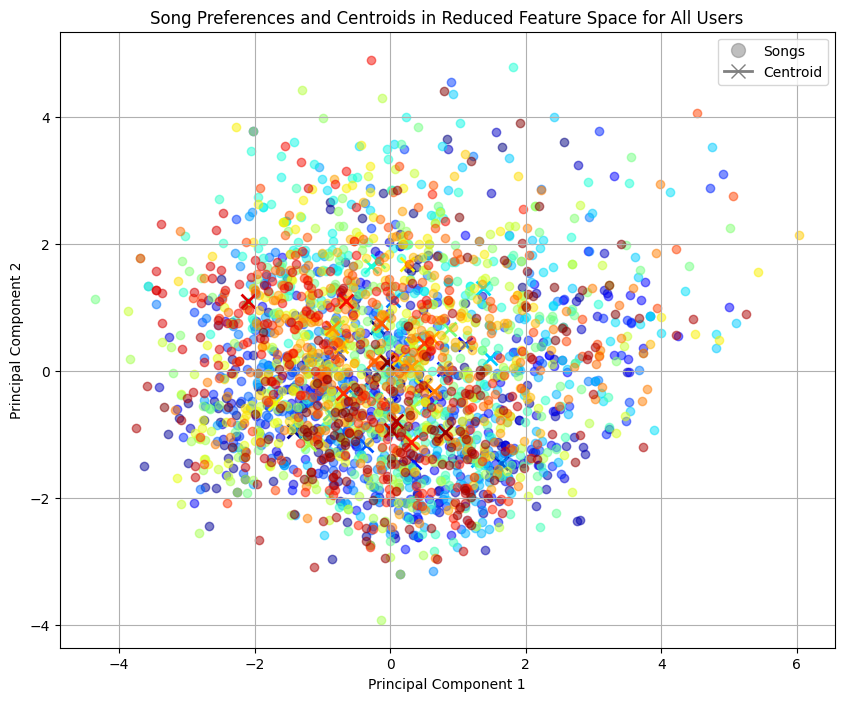

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the rest of your code is unchanged and correct up to this point

# Generate a color map for each user
unique_users = df_pca['user_id'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_users)))
user_color_map = {user_id: color for user_id, color in zip(unique_users, colors)}

plt.figure(figsize=(10, 8))

# Plot songs and centroids for all users on the same plot
for user_id, color in user_color_map.items():
    # Plot songs for each user
    user_songs = df_pca[df_pca['user_id'] == user_id]
    plt.scatter(user_songs['PC1'], user_songs['PC2'], color=color, alpha=0.5, label=f'User {user_id} Songs')
    
    # Plot user centroid
    centroid = user_centroids_pca.loc[user_id]
    plt.scatter(centroid['PC1'], centroid['PC2'], color=color, edgecolors='k', marker='x', s=100, lw=2, label=f'User {user_id} Centroid')

# Because we have many legends (each user + their centroid), let's simplify the legend
# Create custom legends
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=0, marker='o', markersize=10, alpha=0.5, label='Songs'),
                Line2D([0], [0], color='gray', marker='x', markersize=10, lw=2, label='Centroid')]
plt.legend(custom_lines, ['Songs', 'Centroid'])

plt.title('Song Preferences and Centroids in Reduced Feature Space for All Users')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


/var/folders/sw/6q2vf2dx0r502xm9jxzvdxzc0000gn/T/ipykernel_40432/3644205286.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroid['PC1'], centroid['PC2'], color=color, edgecolors='k', marker='x', s=100, lw=2, label=f'User {user_id}')


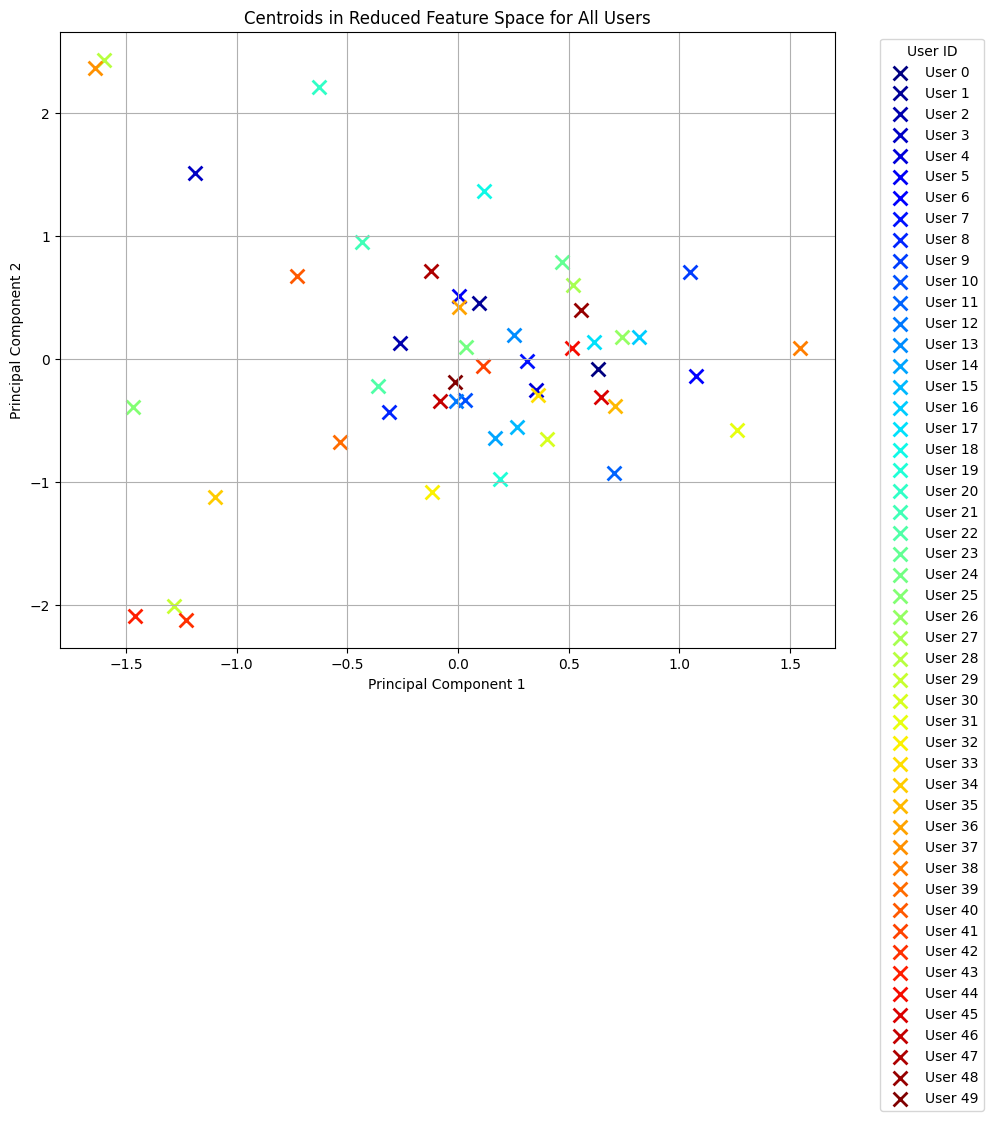

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the rest of your code is unchanged and correct up to this point

# Generate a color map for each user
unique_users = df_pca['user_id'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_users)))
user_color_map = {user_id: color for user_id, color in zip(unique_users, colors)}

plt.figure(figsize=(10, 8))

# Plot centroids for all users
for user_id, color in user_color_map.items():
    # Retrieve user centroid
    centroid = user_centroids_pca.loc[user_id]
    plt.scatter(centroid['PC1'], centroid['PC2'], color=color, edgecolors='k', marker='x', s=100, lw=2, label=f'User {user_id}')

plt.title('Centroids in Reduced Feature Space for All Users')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="User ID", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement to avoid overlap
plt.grid(True)
plt.show()


In [52]:
df.head()

,user_id,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,valence,tempo,duration_minutes,track_name_preprocessed,playlist_name_sentiment,track_name_sentiment,intensity_zone,intensity_zone_encoded,cluster,affinity_score
0,0,0hv6ku4431kPrjbpBBspw3,Animals - Original Mix,6098,5,0N5QcojgdA6aP9oQ7yYG9A,1148,2013-07-01,gym melbourne house,5BqOZpVEqRDfZScvW1QUyA,...,0.0376,128.007,5.07,animals original mix,0.000000,0.375,Zone 4 (Hard),3,10,0.285740
1,0,6uYAPqxP69zfpCbsTHXgiz,Cater 2 U,2462,62,0b6ivSFfDs38MG7aLn9rvO,4221,2004-11-16,hip hop rnb,0Ar0Ng9DlAWZtSPBvOQgOa,...,0.4640,125.802,4.09,cater u,0.000000,0.000,Zone 3 (Moderate),2,14,0.506501
2,0,1gzIbdFnGJ226LTl0Cn2SX,White Wedding - Pt. 1,1083,68,5ebh0MxkqELmk50xHj2b4k,2079,1982-01-01,hard rock cafe,55ybnG2z8rpTIerRfnCsw6,...,0.7280,147.193,4.20,white wedding pt,-0.291667,0.000,Zone 5 (Maximum),4,0,0.394577
3,0,2vX03yHcVtFUg2ZMuzhLhS,Outlaw - Original Mix,5252,0,7jV5akfXEXsoNsqrekDCyX,12116,2014-04-21,latin village,3JcJCsvBnRsA6oc7eUYDSB,...,0.8560,127.998,4.81,outlaw original mix,0.000000,0.375,Zone 4 (Hard),3,10,0.286522
4,0,38LrhW3eQSt3cK88dkvl5e,Misty Night Cruising,5066,33,24sd1ZTrjjabj0A54XK0RP,11054,1984-12-21,city pop シティーポップ,3j2osvmecEao5nmo9jZ5df,...,0.5190,146.518,4.46,misty night cruising,0.000000,0.000,Zone 5 (Maximum),4,0,0.292567


In [4]:
df.to_csv('../datasets/user_song_affinities_df.csv', index=False)